# Text Analysis and Topic Modelling

Author: Jesús Cid-Sueiro

Date: 2016/04/03

Last review: 2016/11/16

In [5]:
%matplotlib inline

# Required imports
from wikitools import wiki
from wikitools import category

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import pylab

from test_helper import Test

import gensim
import lda
import lda.datasets

## 1. Corpus acquisition.
In this notebook we will explore some tools for text analysis available from Python toolboxes.

To do so, we will explore and analyze collections of Wikipedia articles from a given category, using `wikitools`, that makes the capture of content from wikimedia sites very easy.

(*As a side note, there are many other available text collections to work with. In particular, the NLTK library has many examples, that you can explore using the `nltk.download()` tool*.

    import nltk
    nltk.download()

*for instance, you can take the gutemberg dataset*

    Mycorpus = nltk.corpus.gutenberg
    text_name = Mycorpus.fileids()[0]
    raw = Mycorpus.raw(text_name)
    Words = Mycorpus.words(text_name)

*Also, tools like Gensim or Sci-kit learn include text databases to work with*).

In order to use Wikipedia data, we will select a single category of articles:

In [8]:
site = wiki.Wiki("https://en.wikipedia.org/w/api.php")
# Select a category with a reasonable number of articles (>100)
cat = "Economics"
cat = "Pseudoscience"
print cat

Pseudoscience


You can try with any other categories, but take into account that some categories may contain very few articles. Select a category with at least 100 articles. You can browse the wikipedia category tree here, https://en.wikipedia.org/wiki/Category:Contents, for instance, and select the appropriate one.

We start downloading the text collection.

In [9]:
# Loading category data. This may take a while
print "Loading category data. This may take a while..."
cat_data = category.Category(site, cat)

corpus_titles = []
corpus_text = []

for n, page in enumerate(cat_data.getAllMembersGen()):
    print "\r Loading article {0}".format(n + 1),
    corpus_titles.append(page.title)
    corpus_text.append(page.getWikiText())

n_art = len(corpus_titles)
print "\nLoaded " + str(n_art) + " articles from category " + cat

Loading category data. This may take a while...
 Loading article 363 
Loaded 363 articles from category Pseudoscience


Now, we have stored the whole text collection in two lists:

* `corpus_titles`, which contains the titles of the selected articles
* `corpus_text`, with the text content of the selected wikipedia articles

You can browse the content of the wikipedia articles to get some intuition about the kind of documents that will be processed.

In [10]:
n = 5
print corpus_titles[n]
print corpus_text[n]

All About Radiation
[[File:AllAboutRadiation.jpg|thumb|First edition]]
'''''All About Radiation''''' is one of the [[L. Ron Hubbard bibliography|books]] by [[L. Ron Hubbard]] that form the canonical texts of [[Scientology]],<ref>{{cite book|last=Rothstein|first=Mikael|authorlink=Mikael Rothstein|title=The invention of sacred tradition|editor=James R. Lewis|editor2=Olav Hammer|publisher=Cambridge University Press|year=2007|pages=21|chapter=Scientology, scripture and sacred tradition|isbn=978-0-521-86479-4|oclc=154706390}}</ref> although it is no longer promoted by the Church of Scientology nor included in their "Basics" book canon. Its first printing was from HASI ([[Hubbard Association of Scientologists International]]) by way of the Speedwell Printing Company, [[Kent, England]], 1957. Later editions were published by the [[Church of Scientology]]'s in-house publisher [[Bridge Publications (Scientology)|Bridge Publications]]. It is controversial for its claims, amongst other things, th

## 2. Corpus Processing

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization
3. Cleaning
4. Vectorization

### 2.1. Tokenization

For the first steps, we will use some of the powerfull methods available from the [Natural Language Toolkit](http://www.nltk.org). In order to use the `word_tokenize` method from nltk, you might need to get the appropriate libraries using `nltk.download()`. You must select option "d) Download", and identifier "punkt"

In [11]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "punkt"
# nltk.download()

**Task**: Insert the appropriate call to `word_tokenize` in the code below, in order to get the tokens list corresponding to each Wikipedia article:

In [12]:
corpus_tokens = []

for n, art in enumerate(corpus_text): 
    print "\rTokenizing article {0} out of {1}".format(n + 1, n_art),
    # This is to make sure that all characters have the appropriate encoding.
    art = art.decode('utf-8')  
    
    # Tokenize each text entry. 
    # scode: tokens = <FILL IN>
    tokens = word_tokenize(art)
    
    # Add the new token list as a new element to corpus_tokens (that will be a list of lists)
    # scode: <FILL IN>
    corpus_tokens.append(tokens)

print "\n The corpus has been tokenized. Let's check some portion of the first article:"
print corpus_tokens[0][0:30]

Tokenizing article 363 out of 363 
 The corpus has been tokenized. Let's check some portion of the first article:
[u'{', u'{', u'see', u'also|List', u'of', u'topics', u'characterized', u'as', u'pseudoscience', u'}', u'}', u'{', u'{', u'broader|Pseudo-scholarship', u'}', u'}', u'{', u'{', u'Science|phil/hist', u'}', u'}', u"'", u"''", u'Pseudoscience', u"''", u"'", u'is', u'a', u'term', u'used']


In [13]:
Test.assertEquals(len(corpus_tokens), n_art, "The number of articles has changed unexpectedly")
Test.assertTrue(len(corpus_tokens) >= 100, 
                "Your corpus_tokens has less than 100 articles. Consider using a larger dataset")

1 test passed.
1 test passed.


### 2.2. Homogeneization

By looking at the tokenized corpus you may verify that there are many tokens that correspond to punktuation signs and other symbols that are not relevant to analyze the semantic content. They can be removed using the stemming tool from `nltk`.

The homogeneization process will consist of:

1. Removing capitalization: capital alphabetic characters will be transformed to their corresponding lowercase characters.
2. Removing non alphanumeric tokens (e.g. punktuation signs)
3. Stemming/Lemmatization: removing word terminations to preserve the root of the words and ignore grammatical information.

#### 2.2.1. Filtering

Let us proceed with the filtering steps 1 and 2 (removing capitalization and non-alphanumeric tokens).

**Task**: Convert all tokens in `corpus_tokens` to lowercase (using `.lower()` method) and remove non alphanumeric tokens (that you can detect with `.isalnum()` method). You can do it in a single line of code...

In [14]:
# Select stemmer.
stemmer = nltk.stem.SnowballStemmer('english')
corpus_filtered = []

for n, token_list in enumerate(corpus_tokens):
    print "\rFiltering article {0} out of {1}".format(n + 1, n_art),
    
    # Convert all tokens in token_list to lowercase, remove non alfanumeric tokens and stem.
    # Store the result in a new token list, clean_tokens.
    # scode: filtered_tokens = <FILL IN>
    filtered_tokens = [token.lower() for token in token_list if token.isalnum()]
    
    # Add art to corpus_filtered
    # scode: <FILL IN>
    corpus_filtered.append(filtered_tokens)

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_filtered[0][0:30]

Filtering article 363 out of 363 
Let's check the first tokens from document 0 after stemming:
[u'see', u'of', u'topics', u'characterized', u'as', u'pseudoscience', u'pseudoscience', u'is', u'a', u'term', u'used', u'to', u'describe', u'a', u'claim', u'belief', u'or', u'practice', u'presented', u'as', u'but', u'which', u'does', u'not', u'adhere', u'to', u'the', u'scientific', u'method', u'tag']


In [15]:
Test.assertTrue(all([c==c.lower() for c in corpus_filtered[23]]), 'Capital letters have not been removed')
Test.assertTrue(all([c.isalnum() for c in corpus_filtered[13]]), 'Non alphanumeric characters have not been removed')

1 test passed.
1 test passed.


#### 2.2.2. Stemming vs Lemmatization

At this point, we can choose between applying a simple stemming or ussing lemmatization. We will try both to test their differences.

**Task**: Apply the `.stem()` method, from the stemmer object created in the first line, to `corpus_filtered`.

In [16]:
# Select stemmer.
stemmer = nltk.stem.SnowballStemmer('english')
corpus_stemmed = []

for n, token_list in enumerate(corpus_filtered):
    print "\rStemming article {0} out of {1}".format(n + 1, n_art),
    
    # Convert all tokens in token_list to lowercase, remove non alfanumeric tokens and stem.
    # Store the result in a new token list, clean_tokens.
    # scode: stemmed_tokens = <FILL IN>
    stemmed_tokens = [stemmer.stem(token) for token in token_list]
    
    # Add art to the stemmed corpus
    # scode: <FILL IN>
    corpus_stemmed.append(stemmed_tokens)

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_stemmed[0][0:30]

Stemming article 363 out of 363 
Let's check the first tokens from document 0 after stemming:
[u'see', u'of', u'topic', u'character', u'as', u'pseudosci', u'pseudosci', u'is', u'a', u'term', u'use', u'to', u'describ', u'a', u'claim', u'belief', u'or', u'practic', u'present', u'as', u'but', u'which', u'doe', u'not', u'adher', u'to', u'the', u'scientif', u'method', u'tag']


In [17]:
Test.assertTrue((len([c for c in corpus_stemmed[0] if c!=stemmer.stem(c)]) < 0.1*len(corpus_stemmed[0])), 
                'It seems that stemming has not been applied properly')

1 test passed.


Alternatively, we can apply lemmatization. For english texts, we can use the lemmatizer from NLTK, which is based on [WordNet](http://wordnet.princeton.edu). If you have not used wordnet before, you will likely need to download it from nltk

In [22]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "wordnet"
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

**Task**: Apply the `.lemmatize()` method, from the WordNetLemmatizer object created in the first line, to `corpus_filtered`.

In [23]:
wnl = WordNetLemmatizer()

# Select stemmer.
corpus_lemmat = []

for n, token_list in enumerate(corpus_filtered):
    print "\rLemmatizing article {0} out of {1}".format(n + 1, n_art),
    
    # scode: lemmat_tokens = <FILL IN>
    lemmat_tokens = [wnl.lemmatize(token) for token in token_list]

    # Add art to the stemmed corpus
    # scode: <FILL IN>
    corpus_lemmat.append(lemmat_tokens)

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_lemmat[0][0:30]

Lemmatizing article 363 out of 363 
Let's check the first tokens from document 0 after stemming:
[u'see', u'of', u'topic', u'characterized', u'a', u'pseudoscience', u'pseudoscience', u'is', u'a', u'term', u'used', u'to', u'describe', u'a', u'claim', u'belief', u'or', u'practice', u'presented', u'a', u'but', u'which', u'doe', u'not', u'adhere', u'to', u'the', u'scientific', u'method', u'tag']


One of the advantages of the lemmatizer method is that the result of lemmmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization.

However, without using contextual information, lemmatize() does not remove grammatical differences. This is the reason why "is" or "are" are preserved and not replaced by infinitive "be".

As an alternative, we can apply .lemmatize(word, pos), where 'pos' is a string code specifying the part-of-speech (pos), i.e. the grammatical role of the words in its sentence. For instance, you can check the difference between `wnl.lemmatize('is')` and `wnl.lemmatize('is, pos='v')`.

### 2.3. Cleaning

The third step consists of removing those words that are very common in language and do not carry out usefull semantic content (articles, pronouns, etc).

Once again, we might need to load the stopword files using the download tools from `nltk`

In [24]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "stopwords"
# nltk.download()

** Task**: In the second line below we read a list of common english stopwords. Clean `corpus_stemmed` by removing all tokens in the stopword list.

In [25]:
corpus_clean = []
stopwords_en = stopwords.words('english')
n = 0
for token_list in corpus_stemmed:
    n += 1
    print "\rRemoving stopwords from article {0} out of {1}".format(n, n_art),

    # Remove all tokens in the stopwords list and append the result to corpus_clean
    # scode: clean_tokens = <FILL IN>
    clean_tokens = [token for token in token_list if token not in stopwords_en]    

    # scode: <FILL IN>
    corpus_clean.append(clean_tokens)
    
print "\n Let's check tokens after cleaning:"
print corpus_clean[0][0:30]

Removing stopwords from article 363 out of 363 
 Let's check tokens after cleaning:
[u'see', u'topic', u'character', u'pseudosci', u'pseudosci', u'term', u'use', u'describ', u'claim', u'belief', u'practic', u'present', u'doe', u'adher', u'scientif', u'method', u'tag', u'pretend', u'spurious', u'scienc', u'collect', u'relat', u'belief', u'world', u'mistaken', u'regard', u'base', u'scientif', u'method', u'status']


In [26]:
Test.assertTrue(len(corpus_clean) == n_art, 'List corpus_clean does not contain the expected number of articles')
Test.assertTrue(len([c for c in corpus_clean[0] if c in stopwords_en])==0, 'Stopwords have not been removed')

1 test passed.
1 test passed.


### 2.4. Vectorization

Up to this point, we have transformed the raw text collection of articles in a list of articles, where each article is a collection of the word roots that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

In [27]:
# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpus_clean)
n_tokens = len(D)

print "The dictionary contains {0} tokens".format(n_tokens)
print "First tokens in the dictionary: "
for n in range(10):
    print str(n) + ": " + D[n]

The dictionary contains 32867 tokens
First tokens in the dictionary: 
0: demand
1: four
2: edward
3: testabl
4: 20good
5: everi
6: risk
7: voic
8: distort
9: quantif


In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transform any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

** Task**: Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every article in `corpus_clean`. The result must be a new list named `corpus_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [29]:
# Transform token lists into sparse vectors on the D-space
# scode: corpus_bow = <FILL IN>
corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]

In [30]:
Test.assertTrue(len(corpus_bow)==n_art, 'corpus_bow has not the appropriate size') 

1 test passed.


At this point, it is good to make sure to understand what has happened. In `corpus_clean` we had a list of token lists. With it, we have constructed a Dictionary, `D`, which assign an integer identifier to each token in the corpus.
After that, we have transformed each article (in `corpus_clean`) in a list tuples `(id, n)`. 

In [31]:
print "Original article (after cleaning): "
print corpus_clean[0][0:30]
print "Sparse vector representation (first 30 components):"
print corpus_bow[0][0:30]
print "The first component, {0} from document 0, states that token 0 ({1}) appears {2} times".format(
    corpus_bow[0][0], D[0], corpus_bow[0][0][1])

Original article (after cleaning): 
[u'see', u'topic', u'character', u'pseudosci', u'pseudosci', u'term', u'use', u'describ', u'claim', u'belief', u'practic', u'present', u'doe', u'adher', u'scientif', u'method', u'tag', u'pretend', u'spurious', u'scienc', u'collect', u'relat', u'belief', u'world', u'mistaken', u'regard', u'base', u'scientif', u'method', u'status']
Sparse vector representation (first 30 components):
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 155), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2), (24, 5), (25, 21), (26, 5), (27, 1), (28, 1), (29, 1)]
The first component, (0, 1) from document 0, states that token 0 (demand) appears 1 times


Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

These sparse vectors will be the inputs to the topic modeling algorithms.

Note that, at this point, we have built a Dictionary containing

In [32]:
print "{0} tokens".format(len(D))

32867 tokens


and a bow representation of a corpus with

In [33]:
print "{0} Wikipedia articles".format(len(corpus_bow))

363 Wikipedia articles


Before starting with the semantic analyisis, it is interesting to observe the token distribution for the given corpus.

In [34]:
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in corpus_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count
    # scode: <FILL IN>
    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

`ids_sorted` is a list of all token ids, sorted by decreasing number of occurrences in the whole corpus. For instance, the most frequent term is 

In [35]:
print D[ids_sorted[0]]

ref


which appears

In [36]:
print "{0} times in the whole corpus".format(tf_sorted[0])

16390.0 times in the whole corpus


In the following we plot the most frequent terms in the corpus.

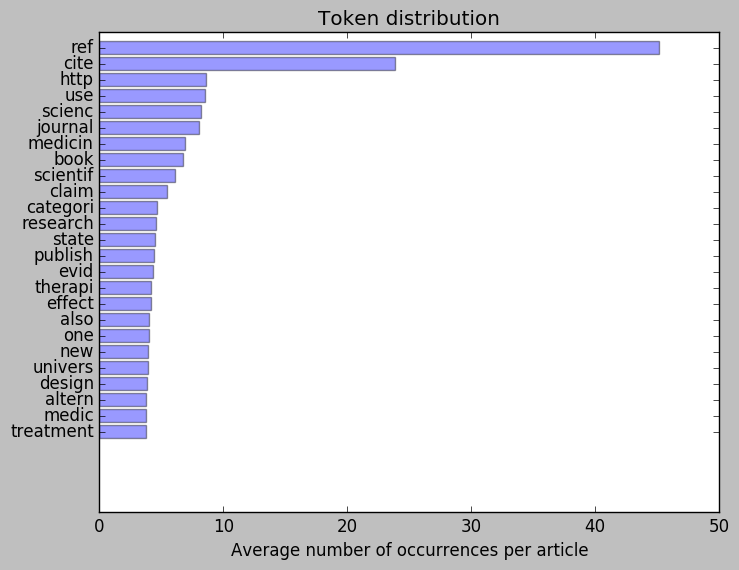

In [37]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

# Example data
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

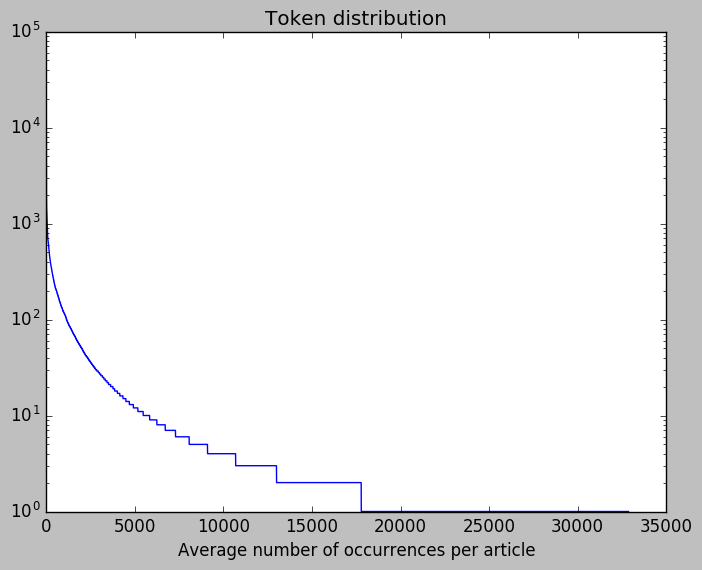

In [38]:
# SORTED TOKEN FREQUENCIES:

# Example data
plt.semilogy(tf_sorted)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

** Exercise**: There are usually many tokens that appear with very low frequency in the corpus. Count the number of tokens appearing only once, and what is the proportion of them in the token list.

In [39]:
# scode: <WRITE YOUR CODE HERE>
# Example data
cold_tokens = [D[i] for i in ids_sorted if tf_sorted[i]==1]

print "There are {0} cold tokens, which represent {1}% of the total number of tokens in the dictionary".format(
    len(cold_tokens), float(len(cold_tokens))/n_tokens*100)

There are 15092 cold tokens, which represent 45.9183983935% of the total number of tokens in the dictionary


** Exercise**: Represent graphically those 20 tokens that appear in the highest number of articles. Note that you can use the code above (headed by `# SORTED TOKEN FREQUENCIES`) with a very minor modification.

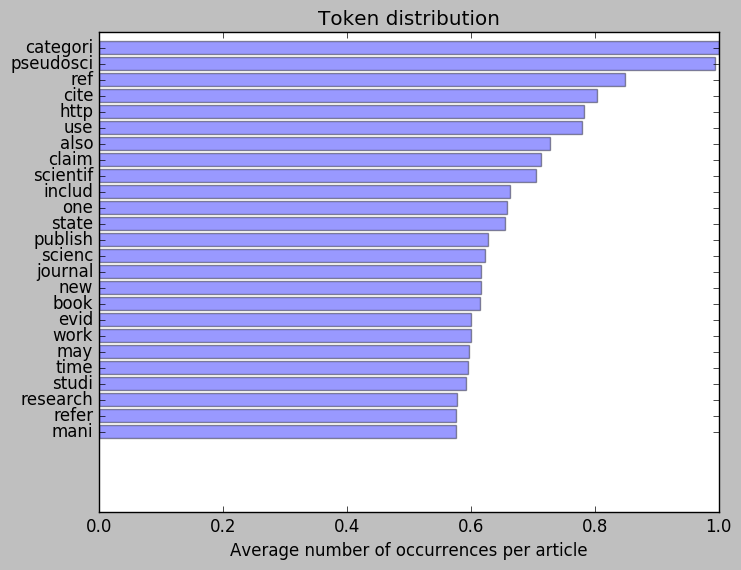

In [40]:
# scode: <WRITE YOUR CODE HERE>

# SORTED TOKEN FREQUENCIES (I):
# Count the number of occurrences of each token.
token_count2 = np.zeros(n_tokens)
for x in corpus_bow_flat:
    token_count2[x[0]] += (x[1]>0)

# Sort by decreasing number of occurences
ids_sorted2 = np.argsort(- token_count2)
tf_sorted2 = token_count2[ids_sorted2]

# SORTED TOKEN FREQUENCIES (II):
# Example data
n_bins = 25
hot_tokens2 = [D[i] for i in ids_sorted2[n_bins-1::-1]]
y_pos2 = np.arange(len(hot_tokens2))
z2 = tf_sorted2[n_bins-1::-1]/n_art

plt.barh(y_pos2, z2, align='center', alpha=0.4)
plt.yticks(y_pos2, hot_tokens2)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

** Exercise**: Count the number of tokens appearing only in a single article.


In [41]:
# scode: <WRITE YOUR CODE HERE>

** Exercise** (*All in one*): Note that, for pedagogical reasons, we have used a different `for` loop for each text processing step creating a new `corpus_xxx` variable after each step. For very large corpus, this could cause memory problems. 

As a summary exercise, repeat the whole text processing, starting from corpus_text up to computing the bow, with the following modifications:

1. Use a single `for` loop, avoiding the creation of any intermediate corpus variables.
2. Use lemmatization instead of stemming.
3. Remove all tokens appearing in only one document and less than 2 times.
4. Save the result in a new variable `corpus_bow1`.

In [42]:
# scode: <WRITE YOUR CODE HERE>

** Exercise** (*Visualizing categories*): Repeat the previous exercise with a second wikipedia category. For instance, you can take "communication". 

1. Save the result in variable `corpus_bow2`.
2. Determine the most frequent terms in `corpus_bow1` (`term1`) and `corpus_bow2` (`term2`).
3. Transform each article in `corpus_bow1` and `corpus_bow2` into a 2 dimensional vector, where the first component is the frecuency of `term1` and the second component is the frequency of `term2`
4. Draw a dispersion plot of all 2 dimensional points, using a different marker for each corpus. Could you differentiate both corpora using the selected terms only? What if the 2nd most frequent term is used?
    

In [43]:
# scode: <WRITE YOUR CODE HERE>

** Exercise ** (bigrams): `nltk` provides an utility to compute n-grams from a list of tokens, in `nltk.util.ngrams`. Join all tokens in `corpus_clean` in a single list and compute the bigrams. Plot the 20 most frequent bigrams in the corpus.

In [44]:
# scode: <WRITE YOUR CODE HERE>
# Check the code below to see how ngrams works, and adapt it to solve the exercise.
# from nltk.util import ngrams
# sentence = 'this is a foo bar sentences and i want to ngramize it'
# sixgrams = ngrams(sentence.split(), 2)
# for grams in sixgrams:
#     print grams

## 3. Semantic Analysis

The dictionary `D` and the Bag of Words in `corpus_bow` are the key inputs to the topic model algorithms. In this section we will explore two algorithms:

1. Latent Semantic Indexing (LSI)
2. Latent Dirichlet Allocation (LDA)

The topic model algorithms in `gensim` assume that input documents are parameterized using the tf-idf model. This can be done using

In [34]:
tfidf = gensim.models.TfidfModel(corpus_bow)

From now on, tfidf can be used to convert any vector from the old representation (bow integer counts) to the new one (TfIdf real-valued weights):

In [35]:
doc_bow = [(0, 1), (1, 1)]
tfidf[doc_bow]

[(0, 0.9291592838567855), (1, 0.36967962511172514)]

Or to apply a transformation to a whole corpus

In [36]:
corpus_tfidf = tfidf[corpus_bow]
print corpus_tfidf[0][0:5]

### 3.1. Latent Semantic Indexing (LSI)

Now we are ready to apply a topic modeling algorithm. Latent Semantic Indexing is provided by `LsiModel`.

**Task**: Generate a LSI model with 5 topics for `corpus_tfidf` and dictionary `D`. You can check de sintaxis for [gensim.models.LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html).

In [37]:
# Initialize an LSI transformation
n_topics = 5
# scode: lsi = <FILL IN>
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=D, num_topics=n_topics) 

From LSI, we can check both the topic-tokens matrix and the document-topics matrix.

Now we can check the topics generated by LSI. An intuitive visualization is provided by the `show_topics` method.

In [38]:
lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  u'0.198*"capit" + 0.192*"product" + 0.154*"price" + 0.130*"market" + 0.128*"marx" + 0.124*"valu" + 0.112*"economi" + 0.107*"jel" + 0.103*"labor" + 0.098*"rate"'),
 (1,
  u'-0.807*"jel" + -0.472*"cat" + -0.140*"common" + -0.126*"histori" + -0.071*"busi" + -0.070*"manag" + -0.068*"parent" + -0.062*"mathemat" + -0.058*"quantit" + 0.048*"capit"'),
 (2,
  u'-0.337*"capit" + -0.312*"marx" + -0.273*"product" + -0.180*"marxian" + -0.144*"labor" + -0.143*"capitalist" + -0.142*"labour" + -0.138*"surplus" + -0.138*"valu" + 0.131*"cite"'),
 (3,
  u'-0.445*"math" + -0.251*"price" + -0.195*"rate" + -0.160*"inflat" + -0.134*"demand" + -0.132*"curv" + 0.127*"marx" + -0.125*"jel" + -0.111*"labor" + -0.110*"c"'),
 (4,
  u'-0.546*"cat" + 0.402*"jel" + -0.232*"common" + -0.186*"system" + -0.161*"price" + 0.142*"parent" + 0.139*"geographi" + 0.138*"labor" + -0.127*"socialist" + -0.123*"societi"')]

However, a more useful representation of topics is as a list of tuples `(token, value)`. This is provided by the `show_topic` method.

**Task**: Represent the columns of the topic-token matrix as a series of bar diagrams (one per topic) with the top 25 tokens of each topic.

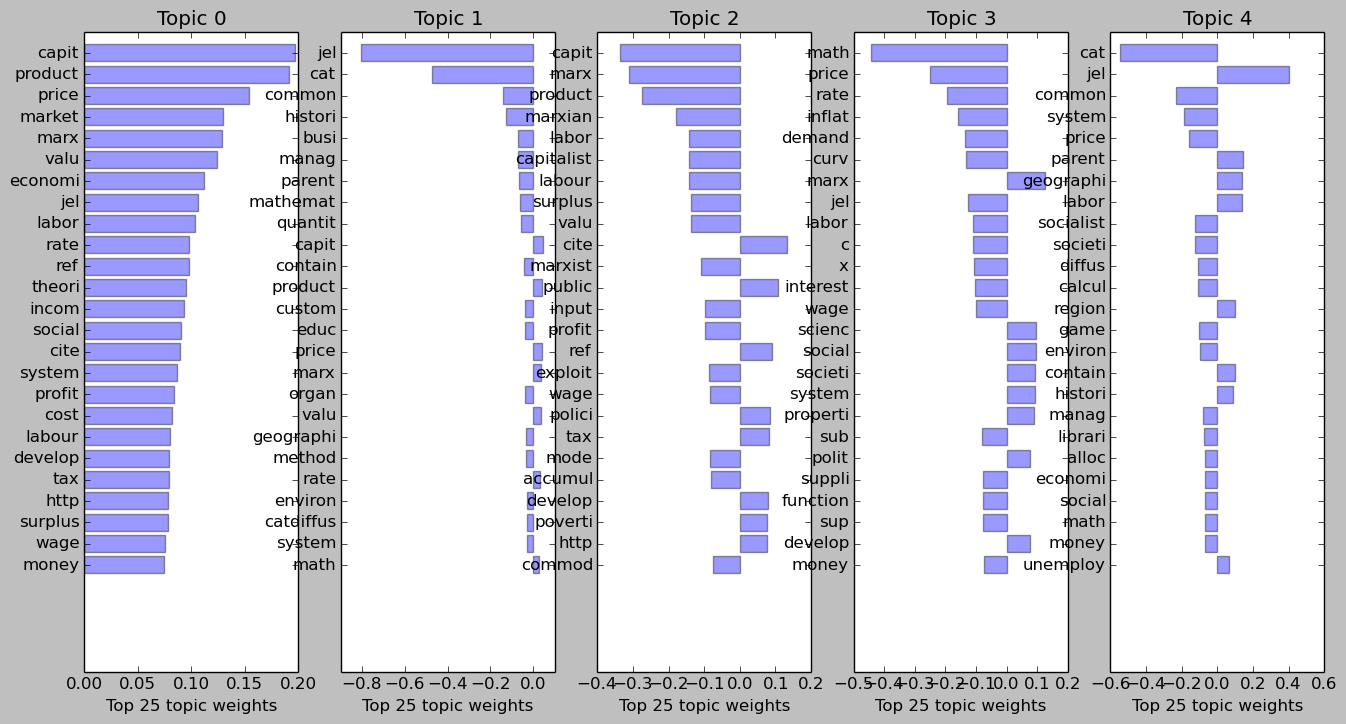

In [39]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

n_bins = 25
    
# Example data
y_pos = range(n_bins-1, -1, -1)

pylab.rcParams['figure.figsize'] = 16, 8  # Set figure size
for i in range(n_topics):
    
    ### Plot top 25 tokens for topic i
    # Read i-thtopic
    # scode: <FILL IN>
    topic_i = lsi.show_topic(i, topn=n_bins)
    tokens = [t[0] for t in topic_i]
    weights = [t[1] for t in topic_i]

    # Plot
    # scode: <FILL IN>
    plt.subplot(1, n_topics, i+1)
    plt.barh(y_pos, weights, align='center', alpha=0.4)
    plt.yticks(y_pos, tokens)
    plt.xlabel('Top {0} topic weights'.format(n_bins))
    plt.title('Topic {0}'.format(i))
    
plt.show()

LSI approximates any document as a linear combination of the topic vectors. We can compute the topic weights for any input corpus entered as input to the `lsi` model.

In [40]:
# On real corpora, target dimensionality of
# 200–500 is recommended as a “golden standard”
# Create a double wrapper over the original 
# corpus bow  tfidf  fold-in-lsi
corpus_lsi = lsi[corpus_tfidf]
print corpus_lsi[0]

[(0, 0.61957367808948083), (1, 0.052110556258995619), (2, 0.10967256197584296), (3, 0.015785752984584071), (4, -0.0048237764373713138)]


**Task**: Find the document with the largest positive weight for topic 0. Compare the document and the topic.

In [41]:
# Extract weights from corpus_lsi
# scode weight0 = <FILL IN>
weight0 = [doc[0][1] for doc in corpus_lsi]

# Locate the maximum positive weight
nmax = np.argmax(weight0)
print nmax
print weight0[nmax]
print corpus_lsi[nmax]

# Get topic 0
# scode: topic_0 = <FILL IN>
topic_0 = lsi.show_topic(0, topn=n_bins)

# Compute a list of tuples (token, wordcount) for all tokens in topic_0, where wordcount is the number of 
# occurences of the token in the article.
# scode: token_counts = <FILL IN>
token_counts = [(t[0], corpus_clean[nmax].count(t[0])) for t in topic_0]

print "Topic 0 is:"
print topic_0
print "Token counts:"
print token_counts

137
0.642432389945
[(0, 0.64243238994543528), (1, 0.11473481546581735), (2, -0.37098450317589599), (3, 0.14093567037864485), (4, -0.013152864961690259)]
Topic 0 is:
[(u'capit', 0.19751042551105993), (u'product', 0.19175238444371881), (u'price', 0.15430589663369032), (u'market', 0.13015591237065585), (u'marx', 0.12847859177358756), (u'valu', 0.12440740418710113), (u'economi', 0.11182154394580036), (u'jel', 0.10653293598031646), (u'labor', 0.1033050091455697), (u'rate', 0.098467290042995606), (u'ref', 0.098242433232117621), (u'theori', 0.095467906235009087), (u'incom', 0.09331707720933094), (u'social', 0.090896278369578046), (u'cite', 0.089381116654996623), (u'system', 0.087190537567418694), (u'profit', 0.083837994157245452), (u'cost', 0.08178289896196432), (u'labour', 0.080391327273451191), (u'develop', 0.079658758551096387), (u'tax', 0.079319321908529569), (u'http', 0.078741281204599556), (u'surplus', 0.078447967466796137), (u'wage', 0.075149699487569777), (u'money', 0.0750186256152517

### 3.2. Latent Dirichlet Allocation (LDA)

There are several implementations of the LDA topic model in python:

* Python library `lda`.
* Gensim module: `gensim.models.ldamodel.LdaModel`
* Sci-kit Learn module: `sklearn.decomposition`

#### 3.2.1. LDA using Gensim

The use of the LDA module in `gensim` is similar to LSI. Furthermore, it assumes that a `tf-idf` parametrization is used as an input, which is not in complete agreement with the theoretical model, which assumes documents represented as vectors of token-counts.

To use LDA in gensim, we must first create a lda model object.

In [42]:
ldag = gensim.models.ldamodel.LdaModel(
    corpus=corpus_tfidf, id2word=D, num_topics=10, update_every=1, passes=10)

In [43]:
ldag.print_topics()

[(0,
  u'0.001*redirect + 0.001*main + 0.001*trap + 0.001*smuggl + 0.001*reus + 0.001*exter + 0.000*bull + 0.000*event + 0.000*topic + 0.000*oecd'),
 (1,
  u'0.001*expenditur + 0.001*uncertainti + 0.001*histori + 0.001*myrdal + 0.001*corridor + 0.001*jew + 0.001*heterodox + 0.001*centuri + 0.001*g + 0.000*dtc'),
 (2,
  u'0.001*neoliber + 0.001*citizenship + 0.001*farmland + 0.001*hyperstagfl + 0.001*timelin + 0.001*parent + 0.001*restor + 0.000*flag + 0.000*collater + 0.000*hazard'),
 (3,
  u'0.001*librari + 0.001*decad + 0.001*arrow + 0.001*lean + 0.001*wicksel + 0.001*apprais + 0.001*lindahl + 0.001*lang + 0.000*foreclosur + 0.000*mathi'),
 (4,
  u'0.001*peac + 0.001*repurpos + 0.001*hour + 0.000*illicit + 0.000*network + 0.000*varianc + 0.000*exponenti + 0.000*stretch + 0.000*uluslararas\u0131 + 0.000*kategori'),
 (5,
  u'0.001*cointegr + 0.001*diffus + 0.001*grey + 0.001*drift + 0.000*dialogu + 0.000*macneil + 0.000*ndash + 0.000*biolog + 0.000*odious + 0.000*secular'),
 (6,
  u'0.

#### 3.2.2. LDA using python lda library

An alternative to gensim for LDA is the lda library from python. It requires a doc-frequency matrix as input

In [44]:
# For testing LDA, you can use the reuters dataset
# X = lda.datasets.load_reuters()
# vocab = lda.datasets.load_reuters_vocab()
# titles = lda.datasets.load_reuters_titles()
X = np.int32(np.zeros((n_art, n_tokens)))
for n, art in enumerate(corpus_bow):
    for t in art:
        X[n, t[0]] = t[1]
print X.shape
print X.sum()

vocab = D.values()
titles = corpus_titles


(316, 14898)
241349


In [45]:
# Default parameters:
# model = lda.LDA(n_topics, n_iter=2000, alpha=0.1, eta=0.01, random_state=None, refresh=10)
model = lda.LDA(n_topics=10, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works

# Show topics...
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: destroy patriarch hussein 253d 177 piric mangano 159


UnicodeEncodeError: 'ascii' codec can't encode character u'\xf3' in position 63: ordinal not in range(128)

Document-topic distribution

In [46]:
doc_topic = model.doc_topic_
for i in range(10):
    print("{} (top topic: {})".format(titles[i], doc_topic[i].argmax()))

Economics (top topic: 2)
Index of economics articles (top topic: 2)
Outline of economics (top topic: 2)
Accounting (top topic: 0)
Additionality (top topic: 6)
Administered prices (top topic: 6)
Affective forecasting (top topic: 1)
Ambrosetti Forum (top topic: 0)
Arrow security (top topic: 6)
Associative economics (top topic: 6)


In [47]:
# This is to apply the model to a new doc(s)
# doc_topic_test = model.transform(X_test)
# for title, topics in zip(titles_test, doc_topic_test):
#    print("{} (top topic: {})".format(title, topics.argmax()))

It allows incremental updates

#### 3.2.2. LDA using Sci-kit Learn

The input matrix to the `sklearn` implementation of LDA contains the token-counts for all documents in the corpus.
`sklearn` contains a powerfull `CountVectorizer` method that can be used to construct the input matrix from the `corpus_bow`. 

First, we will define an auxiliary function to print the top tokens in the model, that has been taken from the `sklearn` documentation.

In [48]:
# Adapted from an example in sklearn site 
# http://scikit-learn.org/dev/auto_examples/applications/topics_extraction_with_nmf_lda.html

# You can try also with the dataset provided by sklearn in 
# from sklearn.datasets import fetch_20newsgroups
# dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                              remove=('headers', 'footers', 'quotes'))

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Now, we need a dataset to feed the Count_Vectorizer object, by joining all tokens in `corpus_clean` in a single string, using a space ' ' as separator.

In [49]:
print("Loading dataset...")
# scode: data_samples = <FILL IN>
data_samples = [" ".join(c) for c in corpus_clean]
print 'Document 0:'
print data_samples[0][0:200], '...'

Loading dataset...
Document 0:
social disambigu theori journal econom econom sidebar econom social scienc describ factor determin product econom distribut econom consumpt econom good servic term come ancient greek wikt wikt hous wi ...


Now we are ready to compute the token counts.

In [50]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
n_features = 1000
n_samples = 2000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print tf[0][0][0]

Extracting tf features for LDA...
done in 0.264s.
  (0, 858)	47
  (0, 920)	86
  (0, 526)	43
  (0, 825)	66
  (0, 278)	24
  (0, 376)	23
  (0, 282)	13
  (0, 735)	74
  (0, 294)	22
  (0, 225)	20
  (0, 436)	72
  (0, 839)	11
  (0, 915)	16
  (0, 196)	5
  (0, 464)	3
  (0, 254)	2
  (0, 550)	18
  (0, 455)	2
  (0, 816)	5
  (0, 461)	5
  (0, 587)	6
  (0, 775)	201
  (0, 182)	43
  (0, 982)	3
  (0, 928)	12
  :	:
  (0, 749)	1
  (0, 106)	1
  (0, 407)	3
  (0, 885)	1
  (0, 386)	1
  (0, 84)	1
  (0, 607)	1
  (0, 482)	1
  (0, 956)	4
  (0, 423)	1
  (0, 989)	5
  (0, 352)	1
  (0, 875)	1
  (0, 567)	1
  (0, 837)	1
  (0, 370)	2
  (0, 873)	1
  (0, 823)	2
  (0, 91)	1
  (0, 339)	1
  (0, 474)	1
  (0, 201)	1
  (0, 947)	2
  (0, 226)	1
  (0, 552)	3


Now we can apply the LDA algorithm. 

**Task**: Create an LDA object with the following parameters: 
    n_topics=n_topics, max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0

In [105]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
# scode: lda = <FILL IN>
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0, 
                                doc_topic_prior=1, topic_word_prior=1000)

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


**Task**: Fit model `lda` with the token frequencies computed by `tf_vectorizer`.

In [106]:
t0 = time()
corpus_lda = lda.fit_transform(tf)
print corpus_lda[0]/np.sum(corpus_lda[0])
print("done in %0.3fs." % (time() - t0))

[  7.53160921e-04   9.96978101e-01   7.56669005e-04   7.33425906e-04
   7.78642792e-04]
done in 2.134s.


In [107]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
ref price cite http account market use good
Topic #1:
ref http cite product price valu market economi
Topic #2:
ref game theori http cite use social nbsp
Topic #3:
ref market product rate http use cite economi
Topic #4:
ref http product cite market develop economi theori
()


In [108]:
topics = lda.components_
topic_probs = [t/np.sum(t) for t in topics]
#print topic_probs[0]
print -np.sort(-topic_probs[0])


[ 0.00110725  0.00105329  0.0010354   0.00103424  0.00102998  0.00102956
  0.00102743  0.001022    0.00102141  0.00102045  0.00101997  0.00101984
  0.00101748  0.00101737  0.00101684  0.00101677  0.0010164   0.00101604
  0.00101603  0.00101598  0.00101584  0.00101489  0.00101484  0.00101478
  0.00101467  0.00101449  0.00101376  0.00101368  0.00101329  0.00101326
  0.00101313  0.00101233  0.0010121   0.00101202  0.00101177  0.00101165
  0.0010114   0.00101135  0.00101121  0.00101105  0.00101099  0.00101092
  0.00101045  0.00101032  0.00101025  0.00101007  0.00101001  0.00100987
  0.00100979  0.00100931  0.0010093   0.0010092   0.00100912  0.001009
  0.00100852  0.00100832  0.00100824  0.00100809  0.00100808  0.00100798
  0.00100794  0.00100791  0.00100789  0.00100783  0.0010077   0.00100766
  0.00100762  0.00100745  0.00100741  0.00100732  0.00100727  0.00100688
  0.00100676  0.00100672  0.00100663  0.0010064   0.00100623  0.00100621
  0.00100598  0.00100597  0.00100562  0.00100562  0.0

**Exercise**: Represent graphically the topic distributions

**Exercise**: Explore the influence of the concentration parameters, $alpha$ (`doc_topic_prior` in `sklearn`) and $eta$(`topic_word_prior`). In particular observe how do topic and document distributions change as these parameters increase.

** Exercise**: The token dictionary and the token distribution have shown that:

1. Some tokens, despite being very frequent in the corpus, have no semantic relevance for topic modeling. Unfortunately, they were not present in the stopword list, and have not been elliminated before the analysis.

2. A large portion of tokens appear only once and, thus, they are not statistically relevant for the inference engine of the topic models.

Revise the entire corpus be removing from the corpus all these sets of terms.


** Exercise**: Note that we have not used the terms in the article titles, though the can be expected to containg relevant words for the topic modeling. Include the title words in the analyisis. In order to give them a special relevante, insert them in the corpus several time, so as to make their words more significant.




** Exercise**: The topic modelling algorithms we have tested in this notebook are non-supervised. This makes them difficult to evaluate objectivelly. In order to test if LDA captures real topics, construct a dataset as the mixture of wikipedia articles from 4 different categories, and test if LDA with 4 topics identifies topics closely related to the original categories.